In [1]:
import sys
sys.path.append('src')
import numpy as np
from scipy.special import erf, erfinv
from scipy.sparse import issparse
from matplotlib import colormaps
import matplotlib.pyplot as plt
from models import *
from train_funcs import *
from visualization import *
rng = np.random.default_rng()

## Model Training

In [2]:
NE, NI, N_syl, N_HVC_per_syl = 600, 150, 3, 3
N_HVC = N_syl * N_HVC_per_syl

In [3]:
peak_rate, kernel_width = 150, 20

In [4]:
T_rend = 600 # Each rendition
N_rend = 35 # Number of renditions
T_burn = 500 # Burning
T = T_burn + N_rend * T_rend # Total

(3, 600)


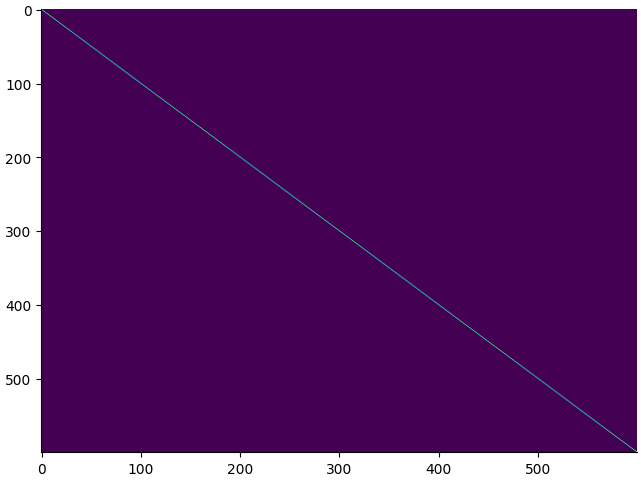

In [5]:
# Syllables and time stamps
# syl = rng.normal(1, 3, size=(N_syl, NE))#
N_shared_channels = 1
syl_cov = block_sym_mat(NE, K=N_shared_channels, var=9, cov=7.5)
plt.imshow(syl_cov)
syl = rng.multivariate_normal(np.ones(NE), syl_cov, size=N_syl)
print(syl.shape)
tsyl_start, tsyl_end, burst_ts = generate_syl_time(T, T_burn, T_rend, N_syl, N_HVC)
save_W_ts = np.round(tsyl_end[-1]).astype(int)

In [6]:
_ = rng.standard_normal((N_HVC, N_rend)) # Little fluctuation
rH = generate_HVC(T, burst_ts, peak_rate+_*0.1, kernel_width+_*0.01)

In [7]:
# (T, NE)
aud = generate_discrete_aud(T, NE, tsyl_start, tsyl_end, syl)
# aud[:T_burn] = rng.normal(0, 1, size=(T_burn, NE))

In [8]:
gen = lognormal_gen
# gen = const_gen
c = 0.5
JEE0, JEI0, JIE0, JII0 = np.array([1, 1.7, 1.2, 1.8]) / 4
sEE, sEI, sIE, sII = np.array([JEE0, JEI0, JIE0, JII0]) * 0.1
JEE = generate_matrix(NE, NE, gen, c, rng=rng, mean=JEE0, std=sEE, sparse=c<=0.5) / np.sqrt(NE)
JEI = generate_matrix(NE, NI, gen, c, rng=rng, mean=JEI0, std=sEI, sparse=c<=0.5) / np.sqrt(NI)
JIE = generate_matrix(NI, NE, gen, c, rng=rng, mean=JIE0, std=sIE, sparse=c<=0.5) / np.sqrt(NE)
JII = generate_matrix(NI, NI, gen, c, rng=rng, mean=JII0, std=sII, sparse=c<=0.5) / np.sqrt(NI)
JEE0_mean = JEE0 / np.sqrt(NE) * c
JEI0_mean = JEI0 / np.sqrt(NI) * c
JIE0_mean = JIE0 / np.sqrt(NE) * c

In [35]:
rEmax, rImax, thE, thI, sE, sI = 50, 100, 0, 0, 2, 2
phiE = lambda x: rEmax/2 * (1 + erf((x - thE) / (np.sqrt(2) * sE)))
phiI = lambda x: rImax/2 * (1 + erf((x - thI) / (np.sqrt(2) * sI)))

In [36]:
w0_mean, w0_std, cW = 1/N_HVC, 0/N_HVC, 0.05
w_inh, wI = w0_mean*cW, 0.0
tauE, tauI, dt = 30, 10, 1

net = EINet(NE, NI, N_HVC, w0_mean, phiE, phiI, tauE, tauI, 
            JEE=JEE.copy(), JEI=JEI.copy(), JIE=JIE.copy(), JII=JII.copy(), 
            w_inh=w_inh, wI=wI, w0_std=w0_std, cW=cW)

100%|███████████████████████████████████████| 999/999 [00:00<00:00, 2484.95it/s]


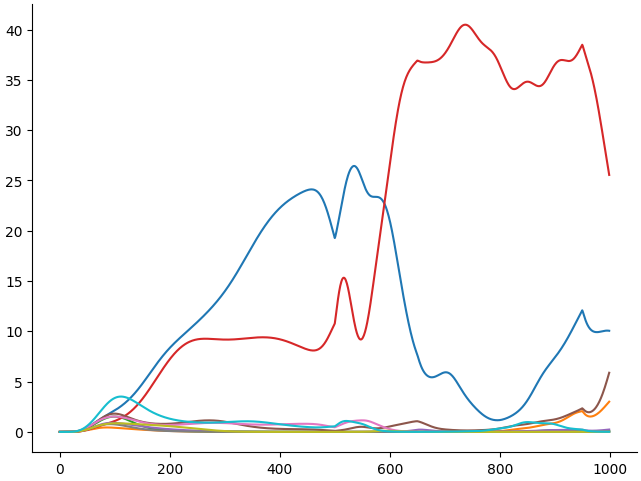

In [37]:
hE0 = rng.normal(loc=-10, scale=0.5, size=NE)
hI0 = rng.normal(loc=-1, scale=0.5, size=NI)
aux = [np.zeros_like(rH[:1000])+rH[:1000].mean(axis=1)[:,None], 
       np.zeros_like(aud[:1000])+aud[:1000].mean(axis=1)[:,None]]
_ = net.sim(hE0, hI0, *aux, [], 1000, dt, 0)
rE, rI, _, _, hE = _
plt.plot(rE[:1000,:10]);

In [38]:
hE0 = rng.normal(loc=-10, scale=0.5, size=NE)
hI0 = rng.normal(loc=-1, scale=0.5, size=NI)
plasticity_kwargs = dict(plasticity=dict(JEE=bilin_hebb_EE), lr=dict(JEE=-5e-2), 
                         tauW=1e5, JEE0_mean=JEE0_mean, asyn_E=10, rE_th=1)
# plasticity_kwargs = dict(plasticity=dict(JEI=bilin_hebb_EI, JIE=bilin_hebb_EI), lr=dict(JEI=5e-2,JIE=5e-2),
#                          tauW=1e5, JIE0_mean=JIE0_mean, JEI0_mean=JIE0_mean, asyn_E=0, asyn_I=0, rE_th=1, rI_th=5)
_ = net.sim(hE0, hI0, rH, aud, save_W_ts, T, dt, 1, **plasticity_kwargs)
rE, rI, Ws, mean_HVC_input, hE = _
for k, v in Ws.items():
    if issparse(v[0]):
        Ws[k] = [_.toarray() for _ in v]

100%|███████████████████████████████████| 21499/21499 [00:20<00:00, 1036.49it/s]


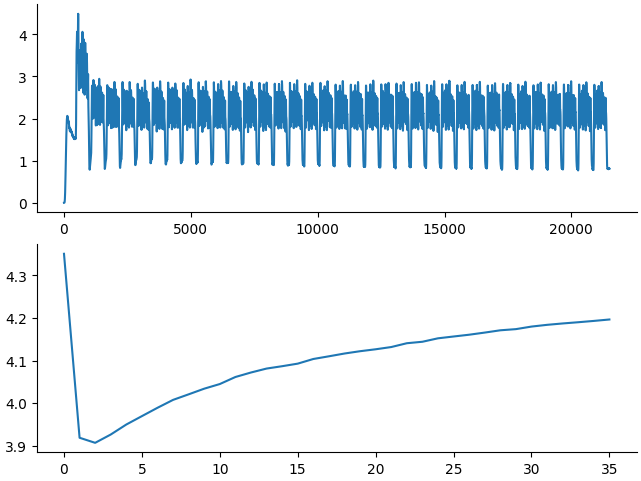

In [39]:
fig, ax = plt.subplots(2)
ax[0].plot(rE.mean(axis=-1))
ax[1].plot([np.sqrt((_**2).sum()) for _ in Ws['JEE']])

/tmp/ipykernel_19679/3669845394.py:2: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0.05)


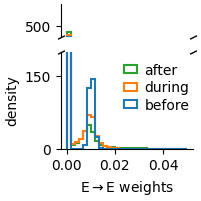

In [40]:
fig, ax = plt.subplots(2, 1, figsize=(2, 2), height_ratios=[1, 3])
fig.subplots_adjust(hspace=0.05)
hist = [Ws['JEE'][_].flatten() for _ in (0, 5, -1)]
for i in range(2):
    ax[i].hist(hist, bins=30, density=True, histtype='step', range=(0, 0.05), lw=1.5,
               label=('before', 'during', 'after'))
ax[0].set(ylim=[300, 900], yticks=[500], xticks=[])
ax[1].set(ylim=[0, 200], yticks=[0, 150], ylabel='density', xlabel=r'E$\to$E weights')
ax[0].spines.bottom.set_visible(False)
ax[1].spines.top.set_visible(False)
d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=5,
              linestyle='none', color='k', mec='k', mew=1, clip_on=False)
ax[0].plot([0, 1], [0, 0], transform=ax[0].transAxes, **kwargs)
ax[1].plot([0, 1], [1, 1], transform=ax[1].transAxes, **kwargs)
ax[1].legend(bbox_to_anchor=(0.38, 0.25), ncols=1, handlelength=1)
fig.savefig('svg/supplementary/EI_rec_weight_dist_over_learning.svg', transparent=True)

In [41]:
# J_corrs = [correlation(_.T, syl) for _ in Ws['JIE']]
# cmap = plt.get_cmap('plasma')
# p, q = 0, 1 # syl idx and hvc idx
# idx = [0, 5, 10, 20, N_rend-1] # rendition idx
# filt = np.where(net.W.toarray() != 0)
# idx_sig = filt[0][filt[1]==q]
# idx_bg = [i for i in range(NE) if i not in idx_sig]
# fig, ax = plt.subplots(1, sharey='all', figsize=(3.5, 2))
# for i, j in enumerate(idx):
#     color = cmap(i/len(idx))
#     sig = J_corrs[i][idx_sig,p]
#     bg = J_corrs[i][idx_bg,p]
#     ax.boxplot([sig, bg], positions=[i/len(idx), 1.5+i/len(idx)],
#                widths=0.5/len(idx), flierprops=dict(ms=2, mec=color), 
#                boxprops=dict(color=color), capprops=dict(color=color),
#                whiskerprops=dict(color=color), medianprops=dict(color=color))
# sm = plt.cm.ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=0, vmax=N_rend))
# fig.colorbar(sm, ax=ax, aspect=25, label='Rendition #')

# ax.set(xlim=[-0.2, 2.5], xticks=[0.5, 2], 
#        xticklabels=['Neurons with\nHVC input', 'Neurons without\nHVC input'])
# ax.set_title('pattern similarity between\nE$\\to$E synaptic weights and tutor song',
#              fontsize=10)
# fig.savefig('svg/EI_rec_train_result.svg')

## Test Model with Different Scenarios

In [42]:
Experiment.AUD_LIST

('correct', 'shuf_syl_idx', 'perturb', 'off')

In [43]:
exp = Experiment(net, rH, syl, noise=1, T_test=T_burn+T_rend, 
                 t_start=tsyl_start[:,:1], t_end=tsyl_end[:,:1])
pert_mean = np.ones(NE)
pert_cov = block_sym_mat(NE, K=N_shared_channels, var=9, cov=7.5)
pert_args = [(pert_mean, pert_cov, 0)]
test_codes = ('correct', 'perturb', 'off', 'correct') # last one for playback
if_sing = (True, True, True, False)
test_names = ('Singing\ncorrect', 'Singing\nperturb',
              'Singing\ndeafen', 'Playback\n')
tests_all = exp.sim_multi(test_codes, if_sing, pert_args * len(test_codes))

100%|█████████████████████████████████████████████| 4/4 [00:01<00:00,  3.24it/s]


In [44]:
rE_block_avgs = [block_apply(_, K=N_shared_channels, func=np.mean)
                 for _ in tests_all['rE']]
syl_block_avgs = block_apply(syl, K=N_shared_channels, func=np.mean)
bos_block_avgs = [block_apply(_, K=N_shared_channels, func=np.mean)
                 for _ in tests_all['bos']]

/home/zg93/Projects/Aiv-Network/src/visualization.py:147: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


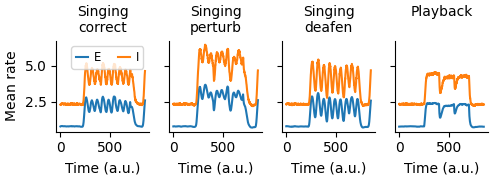

In [45]:
ti, tj = T_burn//2, T_burn+T_rend
fig, ax = plot_tests_mean(tests_all['rE'], tests_all['rI'], test_names, ti, tj)

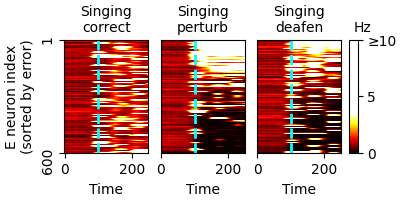

In [46]:
fig, ax = plot_raster_cmp_syl_dsyl(tests_all['rE'][:-1], test_names[:-1], syl[0], 
                                   [_[0]-syl[0] for _ in tests_all['bos']][:-1], 
                                   tsyl_start[0,0], tsyl_end[0,0], 
                                   figsize=(4, 2), plot_z=False, sort_by='e', th=10)
fig.savefig('svg/supplementary/err_response_EIrec.svg', transparent=True)

/home/zg93/Projects/Aiv-Network/src/visualization.py:185: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


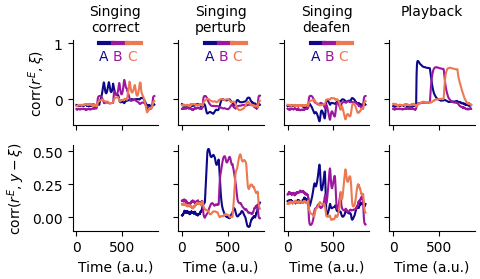

In [47]:
ti, tj = T_burn//2, T_burn + T_rend
ts = [(tsyl_start[i,0]-ti, tsyl_end[i,0]-ti) for i in range(N_syl)] # for plotting bars
aux = [(i, *ts[i]) for i in (0, 1, 2)] # for non-index-shuffled
idx = [(j, *ts[i]) for i, j in enumerate(tests_all['shuff_idx'][1])] # for index-shuffled
so = {0: aux, 1: aux, 2: aux}
fig, ax = plot_tests_corrs(rE_block_avgs, bos_block_avgs, syl_block_avgs, test_names,
                           ti, tj, tid_perturb_input=(1, 2), 
                           syl_order=so, y=1)

/home/zg93/Projects/Aiv-Network/src/visualization.py:219: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


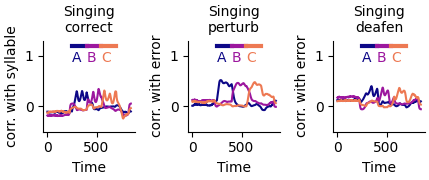

In [48]:
ti, tj = T_burn//2, T_burn + T_rend
ts = [(tsyl_start[i,0]-ti, tsyl_end[i,0]-ti) for i in range(N_syl)] # for plotting bars
aux = [(i, *ts[i]) for i in (0, 1, 2)] # for non-index-shuffled
idx = [(j, *ts[i]) for i, j in enumerate(tests_all['shuff_idx'][1])] # for index-shuffled
# Do not need to show playback
so = {0: aux, 1: aux, 2: aux}
fig, ax = plot_tests_corrs_simple(rE_block_avgs[:-1], bos_block_avgs[:-1], 
                                  syl_block_avgs, test_names[:-1],
                                  ti, tj, tid_perturb_input=(1, 2), 
                                  syl_order=so, y=1.2)
# fig.savefig('svg/corr_EI_rec.svg', transparent=True)

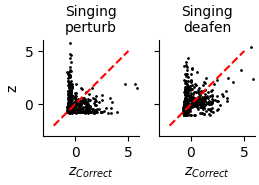

In [53]:
ti, tj = int(tsyl_start[0,0])-100, int(tsyl_end[2,0])+100
fig, ax = plot_ctrl_vs_nonctrl(tests_all['rE'][:-1], test_names[:-1], ti, tj)
# fig, ax = plot_ctrl_vs_nonctrl(rE_block_avgs[:-1], test_names[:-1], ti, tj)
# fig.savefig('svg/joint_dist_c_vs_nc_EI_rec.svg', transparent=True)

In [ ]:
ti, tj = T_burn//2, int(tsyl_end[2,0])
fig, ax = plot_corr_ctrl_nonctrl(tests_all['rE'], test_names, ti, tj, T_burn)
# fig, ax = plot_corr_ctrl_nonctrl(rE_block_avgs, test_names, ti, tj, T_burn)
ax[0].set(ylim=[-1, 1])

In [ ]:
ti, tj = T_burn, int(tsyl_end[0,0])
fig, ax = plot_rate_and_change_dists(tests_all['rE'], test_names, tests_all['rE'][0], ti, tj)
# fig, ax = plot_rate_and_change_dists(rE_block_avgs, test_names, rE_block_avgs[0], ti, tj)

In [ ]:
net_naive = EINet(NE, NI, N_HVC, w0_mean, phiE, phiI, tauE, tauI, 
                  JEE=JEE.copy(), JEI=JEI.copy(), JIE=JIE.copy(), JII=JII.copy(), 
                  w_inh=w_inh, wI=wI, w0_std=w0_std, cW=cW)
net_naive.W = net.W.copy()
exp_naive = Experiment(net_naive, rH, syl, noise=1, T_test=T_burn+T_rend, 
                       t_start=tsyl_start[:,:1], t_end=tsyl_end[:,:1])
playback_naive = exp_naive.sim_multi(['correct'], [False])

In [ ]:
filt = np.where(net.W.toarray() != 0)
# idx_sig = filt[0][(filt[1]==1)|(filt[1]==2)]
idx_sig = np.unique(filt[0])
idx_bg = [i for i in range(NE) if i not in idx_sig]

rE_sig = tests_all['rE'][-1][:,idx_sig].mean(axis=0)
rE_bg = tests_all['rE'][-1][:,idx_bg].mean(axis=0)
rE_pb_sig = playback_naive['rE'][0][:,idx_sig].mean(axis=0)
rE_pb_bg = playback_naive['rE'][0][:,idx_bg].mean(axis=0)

xticks = ['before learning', 'after learning']

fig, ax = plt.subplots(1, figsize=(3, 3))
for j, (k, l) in enumerate(zip(([rE_pb_sig, rE_sig], [rE_pb_bg, rE_bg]), ('with', 'without'))):
    color = 'C%d' % j
    ax.boxplot(k, positions=[0+j*0.2, 1+j*0.2], label='Neurons '+l+'\nHVC input',
               flierprops=dict(ms=2, mec=color), 
               boxprops=dict(color=color), capprops=dict(color=color),
               whiskerprops=dict(color=color), medianprops=dict(color=color))
ax.legend(labelcolor=['C0', 'C1'], handlelength=0.5)
ax.set_xticks(np.arange(len(xticks))+0.1, xticks)
ax.set(ylabel='mean rate due to playback')
fig.tight_layout(pad=0.1)

In [ ]:
filt = np.where(net.W.toarray() != 0)
# idx_sig = filt[0][(filt[1]==1)|(filt[1]==2)]
idx_sig = np.unique(filt[0])
idx_bg = [i for i in range(NE) if i not in idx_sig]

rE_af_sig = tests_all['rE'][-1][:,idx_sig].mean(axis=0)
rE_af_bg = tests_all['rE'][-1][:,idx_bg].mean(axis=0)
rE_bf_sig = playback_naive['rE'][0][:,idx_sig].mean(axis=0)
rE_bf_bg = playback_naive['rE'][0][:,idx_bg].mean(axis=0)

title = ['before learning', 'after learning']
hist_max = max(map(np.max, (rE_bf_sig, rE_bf_bg, rE_af_sig, rE_af_bg)))

fig, ax = plt.subplots(2, sharex='all', figsize=(3, 3))
for j, k in enumerate(([rE_bf_sig, rE_bf_bg], [rE_af_sig, rE_af_bg])):
    ax[j].hist(k, range=(0, hist_max), bins=15, histtype='stepfilled', density=True,
               alpha=0.5, label=['neurons with\nHVC input', 'neurons without\nHVC input'])
    ax[j].set(yscale='log', ylim=[0.001, 2], ylabel=title[j])
ax[1].legend(handlelength=1, handletextpad=0.5)
ax[1].set(xlabel='mean rate due to playback (Hz)')
fig.tight_layout(pad=0.1)
# fig.savefig('svg/EI_rec_pb_mean_rate_before_after.svg')

In [ ]:
filt = np.where(net.W.toarray() != 0)
# idx_sig = filt[0][(filt[1]==1)|(filt[1]==2)]
idx_sig = np.unique(filt[0])
idx_bg = [i for i in range(NE) if i not in idx_sig]

rE_af_sig = tests_all['rE'][-1][:,idx_sig].mean(axis=0)
rE_af_bg = tests_all['rE'][-1][:,idx_bg].mean(axis=0)
rE_bf_sig = playback_naive['rE'][0][:,idx_sig].mean(axis=0)
rE_bf_bg = playback_naive['rE'][0][:,idx_bg].mean(axis=0)

title = ['before learning', 'after learning']

fig, ax = plt.subplots(1, sharex='all', figsize=(3, 3))
ax.hist([rE_af_sig - rE_bf_sig, rE_af_bg - rE_bf_bg],  
        bins=30, histtype='step', density=True,
        label=['with HVC input', 'without HVC input'])
ax.legend(title='Neurons')
ax.set(xlabel='mean rate due to playback')
fig.tight_layout(pad=0.1)